In [1]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# Problem 1

### a) what should the first derivative in dx be?

After following the approach for the centred (2 point) derivative seen in lecture and Numerical Recipes Ch. 5, the extra two points allow us to get the following form for the derivative estimate:

$\frac{1}{12\delta}[f(x-2\delta)-8f(x-\delta)+8f(x+\delta)-f(x+2\delta)]$ 

The full calculation can be found in the appendix

In [2]:
def deriv(f,x,delta):
    return (1/(12*delta))*(f(x-2*delta)-8*f(x-delta)+8*f(x+delta)-f(x+2*delta))

### b) what is the optimal $\delta$ ?

I calculated the optimal derivative based off of the technique shown for the function evaluated at 2 points in Jon's lecture 1 slides. 

This gives $\delta \approx [\frac{f\varepsilon_f}{f^{(5)}}]^\frac{1}{5}$ (see appendix for full calculation). Where $\varepsilon_f$ is the machine precision roundoff error

The $x_c = \frac{f}{f^{(5)}}$ term can be approximated by $x_c = x$ if $x$ is not near zero. I'll pick an $x$ well above 0, just to be careful.

So our approximate $\delta$ will just be $~ (x\varepsilon_f)^\frac{1}{5}$

For single point precision, $\varepsilon_f = 10^{-7} $

For double point precision $\varepsilon_f = 10^{-16}$ - this is what I use here

In [245]:
single_del = (1e-7)**(1/5)
double_del = (1e-16)**(1/5)

print(f'Optimal δ for single point precision: {single_del} \nOptical δ for double point precision: {double_del}')

Optimal δ for single point precision: 0.03981071705534972 
Optical δ for double point precision: 0.000630957344480193


#### Calculating fractional error:

See appendix for full calculation. 

Basically, we want to minimize the sum of the leading term in the expansion error with the roundoff error from machine precision.

We know that $\delta \approx [\frac{f\varepsilon_f}{f^{(5)}}]^\frac{1}{5}$

We can plug this $\delta$ in to our expression for fractional uncertainty: $\frac{e_r + e_t}{|f'|}$, and we can get rid of f and its higher derivatives by assuming that they all share the same characteristic length. This gives us a fractional uncertainty of $\varepsilon_f^\frac{4}{5}$, where $\varepsilon_f$ is approximately the machine precision.

#### Evaluate $f(x) = e^x$

In [246]:
x = 5
fun = np.exp

eps = 1e-16
delta = x*eps**(1/5)

d = deriv(fun,x,delta)
err = eps**(4/5)

print(f'Derivative is: {d}, Error is: {err}')

Derivative is: 148.41340528747506, Error is: 1.584893192461111e-13


#### Evaluate $f(x) = e^{0.01x}$

In [247]:
def exp_001(x):
    return np.exp(0.01*x)

x_new = 5
fun_new = exp_001

eps_new = 1e-16
delta_new = x_new*eps**(1/5)

d_new = deriv(fun_new,x,delta)

print(f'Derivative is: {d_new}, Error is: {err}')

Derivative is: 0.010512710965507434, Error is: 1.584893192461111e-13


Since we know the actual values for the derivatives of these functions, let's compare them to the real solutions. These are pretty accurate!

In [248]:
true_ex = np.exp(x)
true_e_001 = 0.01*np.exp(0.01*x)

print(f'Difference between true and numerical derivative for e^x = {true_ex - d}')
print(f'Difference between true and numerical derivative for e^0.01x = {true_e_001 - d_new}')

Difference between true and numerical derivative for e^x = -0.00024618489845806835
Difference between true and numerical derivative for e^0.01x = -1.7471926683221284e-12


# Problem 2

Here I use an iterative approach to decrease dx until the derivative is stable, i.e., no changes between iterations by a factor of ~1/2 machine precision.

If it doesn't converge, the function will stop at 500 iterations and print an exiting message.

I wanted to implement something along the lines of:
   * take initial dx
   * calculate f'
   * calculate f'''
   * estimate new dx using above method of $dx \approx (x_c\varepsilon)^{1/2}$ where $x_c \approx x, x\neq0$ & repeat until $dx - dx_{previous iteration}$ converges
   
I couldn't figure out how to calculate f''', since if I use a Taylor expansion, then my truncation error on f''' >> truncation error on f, so I felt like this was not the right approach and instead just decided to increment dx by 1/2 every time until the derivative itself converged.

To calculate my error, I still use the fractional error for dx given by _Numerical Methods_ for a 4 point derivative, i.e., $\frac{e_r + e_t}{|f'|} \approx \sqrt{e_f}$. This calculation is very similar for the one done for question 1.

In [128]:
def deriv(fun,x,dx): 
    return (fun(x+dx) - fun(x-dx))/(2*dx)

def ndiff(fun,x,full=False):
        
    #set initial dx = 1
    dx = 1
    deriv_old = 1000 # large number so this doesn't crash at the beginning
    
    diff = 10 # arbitrary large starting value
    
    max_iter = 500
    i = 0
    
    while ((diff > 5e-15) and (i < max_iter)) : # ~ 10x machine precision
        if i > max_iter - 2:
            print('Derivative has not converged. Exiting...')
        i = i+1
        f_prime = deriv(fun,x,dx)
                
        diff = np.abs(deriv_old - f_prime)
        deriv_old = f_prime
        dx = dx/2
    
    if full == True:
        return f_prime,dx,np.sin(1)-f_prime
    
    else:
        return f_prime

Derivative, dx, Error:
(0.5403023064136505, 2.9802322387695312e-08, 0.301168678394246)


#### Running the derivative function with both full = True and full = False

In [249]:
fun = np.sin
x = 1
full = True
derivative = ndiff(fun,x,full)

if full:
    print('Derivative, dx, Error:')
else:
    print('Derivative:')

print(derivative)

Derivative, dx, Error:
(0.5403023064136505, 2.9802322387695312e-08, 0.301168678394246)


In [250]:
fun = np.sin
x = 1
full = False
derivative = ndiff(fun,x,full)

if full:
    print('Derivative, dx, Error:')
else:
    print('Derivative:')

print(derivative)

Derivative:
0.5403023064136505


# Problem 3

I used scipy's interp1d to do a cubic spline interpolation of the data. I chose interp1d because it returns a function that can be used to evaluate temperature at any voltage value easily.

The function only works on voltage values within the range provided by the data, i.e., it does not extrapolate and will return an error if V is outside of this range.

To calculate error, I use boostrap resampling to calculate the interpolation at every second data point and then take the absolute value of the distance between these interpolated points and the data points corresponding to the same voltage. The mean of these values corresponds to the average error, which can be seen below to be $O(10^{-15})$, which is about an order of magnitude greater than machine precision. This means the error is pretty small!

Below are the outputs on the function run with type(V) = float, type(V) = np.array(), and V > max(voltage)

In [259]:
def lakeshore(V,data):
    
    #unpack data
    temp = data[0]
    voltage = data[1]
    
    #plot data
    plt.plot(temp,voltage,'ko')
    plt.xlabel('Temperature [K]')
    plt.ylabel('Voltage [V]')
        
    f = interpolate.interp1d(voltage,temp,kind='cubic')
    
    #plot interpolation
    plt.plot(f(voltage),voltage,'r--')
    plt.legend(['Data','Cubic Spline Interpolation'])
    plt.show()
    
    # interpolate again w/ half the points to get error
    indices = np.arange(0,voltage.size,2)
    voltage_half = voltage[indices]
    temp_half = temp[indices]
    
    f_half = interpolate.interp1d(voltage_half,temp_half,kind='cubic')
    
    dif = f_half(voltage_half) - temp_half #find difference between interpolated and real values
    
    avg_err = np.mean(np.abs(dif)) #the mean of the distance b/w the interpolated points and their true values gives us the error
    
    #arrays for storing output
    interp_temp = np.array(())    

    if (isinstance(V,int) or isinstance(V,float)):
        if (V > max(voltage) or V < min(voltage)):
            print(f'Error: Invalid voltage value. Please enter a value between {min(voltage)} and {max(voltage)}')
            return ['','']
    
        interp_temp = np.append(interp_temp, f(V))
    
    else:
        for v in V:
            if (v > max(voltage) or v < min(voltage)):
                print(f'Error: Invalid voltage value. Please enter a value between {min(voltage)} and {max(voltage)}')
                return ['','']
  
            interp_temp = np.append(interp_temp,f(v))            
    
    return [interp_temp, avg_err]

#### Interpolate for V as a number

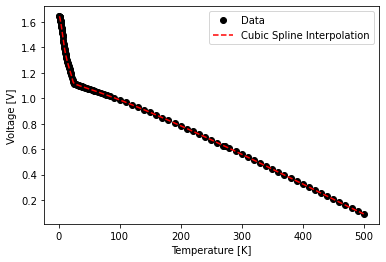

Temperature for V: [13.70254428], Error: 3.5681334430314055e-15


In [260]:
dat = np.loadtxt('lakeshore.txt',unpack=True)
volt = 1.3
volts = np.linspace(0.5,0.7,10)
temp, err = lakeshore(volt,dat)
print(f'Temperature for V: {temp}, Error: {err}')

#### Interpolate for V as an array

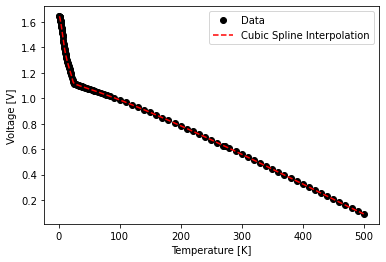

Temperature for V: [325.75028677 316.18032323 306.58558903 296.94064023 287.30114546
 277.46403405 267.84850093 257.94219337 248.08018907 238.12931659]
Error: 3.5681334430314055e-15


In [261]:
volts = np.linspace(0.5,0.7,10)
temp, err = lakeshore(volts,dat)
print(f'Temperature for V: {temp}\nError: {err}')

# Problem 4

The cell below defines the $f = cos(x)$ or Lorentzian, $f = \frac{1}{1+x^2}$ functions that we're going to try to fit to.

I'm using 10 points because that is what is needed to do the rational polynomial interpolation, i.e., n+m where n = 4, m = 5, so for fairness that will be the number of points for all interpolations.

For each approach, since I know the true values of both the cosine function and the Lorentzian, I calculate the accuracy by taking the error as the difference between the interpolated values and the true values.

**For clarity, I've gone over each interpolation in detail for $f = cos(x)$ and then moved on to the Lorentzian function below**

### Cosine Function

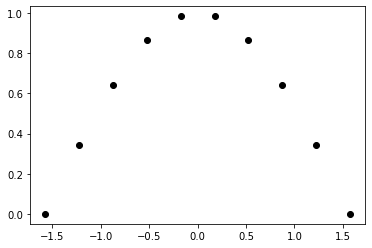

In [203]:
fun = np.cos

x = np.linspace(-np.pi/2,np.pi/2,10)
y = fun(x)
plt.plot(x,y,'ko')

#### Polynomial Interpolation

Fit with polynomial using Scipy's interpolate.BarycentricInterpolator. This function constructs a polynomial passing through the given set of x points and doesn't compute the coefficients of the polynomial so that it remains numerically stable. That's okay here because we don't need it to compute the y value for any x, but rather we want to see how well it fits the entire function.

(This function is good because it allows rapid updating of y_initial points, since the preprocessing does not depend on them. This is not super important here but this is why the function is particularly useful over other scipy interpolate methods)

Error for polynomial fit: 8.890677473886336e-08


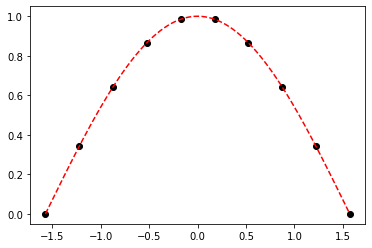

In [204]:
x_fine = np.linspace(-np.pi/2,np.pi/2,1001)

#do a polynomial interpolation and evaluate on fine x to get fine y
interp = interpolate.BarycentricInterpolator(x, y, axis=0)
y_poly = interp(x_fine)

y_true = np.cos(x_fine) #true values b/c we know the true values of the function

plt.plot(x,y,'ko')
plt.plot(x_fine,y_poly,'r--')

print(f'Error for polynomial fit: {np.std(y_true - y_poly)}')

#### Cubic spline interpolation

Fit with cubic spline using scipy (adapted from Jon's cubic spline code). This returns a spline, interpolated from the data points, meaning that derivatives up to third order are continuous.

Error for spline fit: 5.4764056344440255e-05


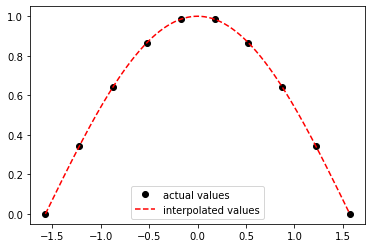

In [205]:
x_fine = np.linspace(-np.pi/2,np.pi/2,1001)
y_fine = np.cos(x_fine)

#spline interpolation
spl=interpolate.splrep(x,y) #generate the spline using scipy
plt.plot(x,y,'ko')
y_spl=interpolate.splev(x_fine,spl) #evaluate the spline on fine x

plt.plot(x_fine,y_spl,'r--')
plt.legend(['actual values','interpolated values'])
print(f'Error for spline fit: {np.std(y_fine - y_spl)}')
plt.show()

#### Rational function interpolation

Adapted from Jon's ratfit_class.py code. A rational interpolation is a ratio of 2 polynomials of degrees n (numerator) and m (denominator). This can give us an exact representation of a polynomial, and is useful for functions with poles. 

We select n and m such that correspond to the number of points we want to fit, in a simple case.

Since a Lorentzian _is_ a rational function, we should get an error of zero $\implies$ our expected error would just be machine precision $\varepsilon_f \approx 10^{-16}$ for a double precision float.

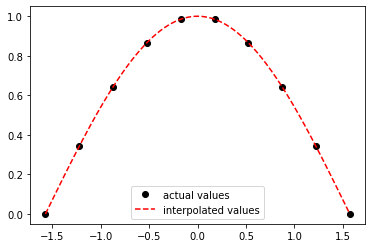

rational function error:  1.219182445837153e-07


In [207]:
n=4 #numerator order
m=5 #denominator order

x=np.linspace(-np.pi/2,np.pi/2,n+m+1)
y=fun(x)

pcols=[x**k for k in range(n+1)]
pmat=np.vstack(pcols)

qcols=[-x**k*y for k in range(1,m+1)]
qmat=np.vstack(qcols)
mat=np.hstack([pmat.T,qmat.T])
coeffs=np.linalg.inv(mat)@y

#now that we have coefficients, we can see how well we did
xfine=np.linspace(-np.pi/2,np.pi/2,1001)

p=0
for i in range(n+1):
    p=p+coeffs[i]*xfine**i
qq=1
for i in range(m):
    qq=qq+coeffs[n+1+i]*xfine**(i+1)

y_pred=p/qq
y_true=fun(xfine)
plt.plot(x,y,'ko')
plt.plot(xfine,y_pred,'r--')
plt.legend(['actual values','interpolated values'])
#plt.plot(xfine,y_pred-y_true)
plt.show()

print('rational function error: ',np.std(y_pred-y_true))

### Lorentzian Function

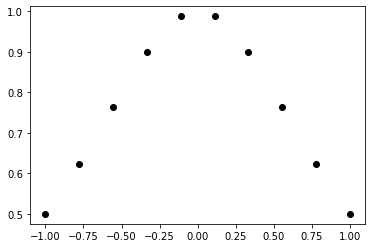

In [196]:
def lorentzian(x):
    return 1/(1+x**2)

fun = lorentzian

x = np.linspace(-1,1,10)
y = fun(x)
plt.plot(x,y,'ko')

#### Polynomial interpolation

Error for polynomial fit: 0.00043320472666995


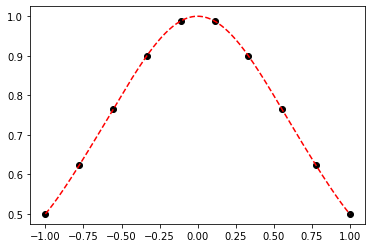

In [197]:
x_fine = np.linspace(-1,1,1001)

#do a polynomial interpolation and evaluate on fine x to get fine y
interp = interpolate.BarycentricInterpolator(x, y, axis=0)
y_poly = interp(x_fine)

y_true = lorentzian(x_fine) #true values b/c we know the true values of the function

plt.plot(x,y,'ko')
plt.plot(x_fine,y_poly,'r--')

print(f'Error for polynomial fit: {np.std(y_true - y_poly)}')

#### Cubic spline interpolation

Error for spline fit: 0.00018162374040159938


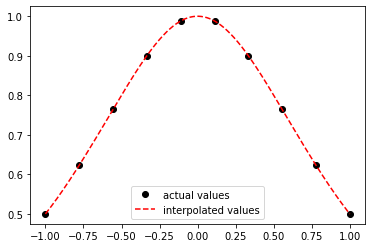

In [198]:
x_fine = np.linspace(-1,1,1001)
y_fine = lorentzian(x_fine)

#spline interpolation
spl=interpolate.splrep(x,y) #generate the spline using scipy
plt.plot(x,y,'ko')
y_spl=interpolate.splev(x_fine,spl) #evaluate the spline on fine x

plt.plot(x_fine,y_spl,'r--')
plt.legend(['actual values','interpolated values'])
print(f'Error for spline fit: {np.std(y_fine - y_spl)}')
plt.show()

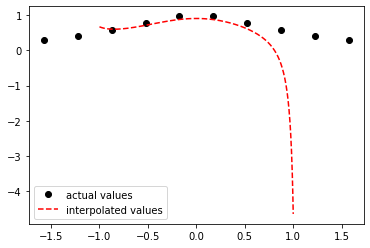

ratfun err is  0.5768673329288364


In [200]:
n=4 #numerator order
m=5 #denominator order

x=np.linspace(-np.pi/2,np.pi/2,n+m+1)
y=fun(x)

pcols=[x**k for k in range(n+1)]
pmat=np.vstack(pcols)

qcols=[-x**k*y for k in range(1,m+1)]
qmat=np.vstack(qcols)
mat=np.hstack([pmat.T,qmat.T])
coeffs=np.linalg.inv(mat)@y

#now that we have coefficients, we can see how well we did
xfine=np.linspace(-1,1,1001)

p=0
for i in range(n+1):
    p=p+coeffs[i]*xfine**i
qq=1
for i in range(m):
    qq=qq+coeffs[n+1+i]*xfine**(i+1)

y_pred=p/qq
y_true=fun(xfine)
plt.plot(x,y,'ko')
plt.plot(xfine,y_pred,'r--')
plt.legend(['actual values','interpolated values'])
#plt.plot(xfine,y_pred-y_true)
plt.show()

print('ratfun err is ',np.std(y_pred-y_true))

We can see in the plot above that the rational fit behaves weirdly around where the denominator = 0. When we plot a higher-order rational function (see below - 3rd order), we get singularities around each node, which produce matrices that are not invertible $\implies$ we can't just use np.linalg.inv, since it just inverts every matrix and does not know how to deal with singularities

np.linalg.pinv is defined in the numpy documentation as:
> "Calculate[s] the generalized inverse of a matrix using its singular-value decomposition (SVD) and includ[es] all large singular values"

So it should be able to handle the singular variables that arise from higher order rational functions

Text(0, 0.5, 'f(x)')

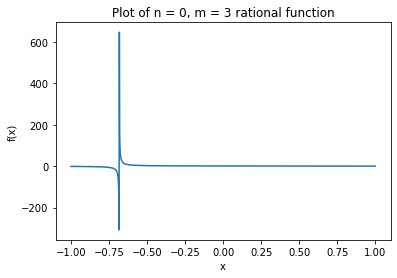

In [137]:
x = np.linspace(-1,1,1000)
plt.plot(x,1/(x**3+x+1))
plt.title('Plot of n = 0, m = 3 rational function')
plt.xlabel('x')
plt.ylabel('f(x)')

Let's run the same rational function fit but just change np.linalg.inv to np.linalg.pinv.

This is a much more reasonable fit! No weird spikes at x = 0 and the error is smaller by ~ 5 orders of magnitude.

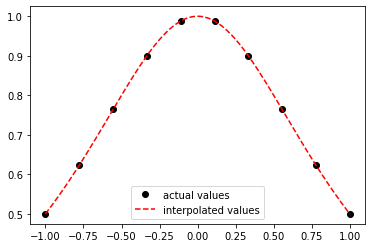

rational function error:  5.533771892702031e-16


In [201]:
n=4 #numerator order
m=5 #denominator order

x=np.linspace(-1,1,n+m+1)
y=fun(x)

pcols=[x**k for k in range(n+1)]
pmat=np.vstack(pcols)

qcols=[-x**k*y for k in range(1,m+1)]
qmat=np.vstack(qcols)
mat=np.hstack([pmat.T,qmat.T])
coeffs=np.linalg.pinv(mat)@y

#now that we have coefficients, we can see how well we did
xfine=np.linspace(-1,1,1001)

p=0
for i in range(n+1):
    p=p+coeffs[i]*xfine**i
qq=1
for i in range(m):
    qq=qq+coeffs[n+1+i]*xfine**(i+1)

y_pred=p/qq
y_true=fun(xfine)
plt.plot(x,y,'ko')
plt.plot(xfine,y_pred,'r--')
plt.legend(['actual values','interpolated values'])
#plt.plot(xfine,y_pred-y_true)
plt.show()

print('rational function error: ',np.std(y_pred-y_true))